# Miniprojeto 2 - Redes Neurais Convolucionais com MNIST

#### Alunos
* Ítalo Rodrigo Barbosa Paulino - irbp
* José Nilton de Oliveira Lima Júnior - jnolj

O objetivo deste mini projeto é construir um classificador para a base de dados MNIST utilizando uma Rede Neural Convolucional (CNN). Para isso, utilizaremos a biblioteca tensorflow em conjunto com o keras para modelar a nossa rede neural e só assim depois treiná-la e avaliar o seu desempenho com base no conjunto de teste disponibilizado pelo dataset.

Esse relatório seguirá o modelo de código comentado, feito em Python3 e utilizando Jupyter Notebook.

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, DepthwiseConv2D, Conv2D, MaxPool2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix

from google.colab import files

O primeiro passo feito foi carregar o dataset do MNIST e normalizar os valores correspondentes aos seus pixels. Logo após isso transformamos a imagem em um array tridimensional, mas com apenas um channel (a imagem é em tons de cinza), pois será essa o tipo de entrada esperada pela nossa rede neural.

In [2]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape(-1, 28, 28, 1), x_test.reshape(-1, 28, 28, 1)

11493376/11490434 [==============================] - 0s 0us/step


(60000, 28, 28, 1)

Em seguida plotamos a distribuição de cada classe, ou seja, quantas instâncias de cada classe está presente no nosso dataset.

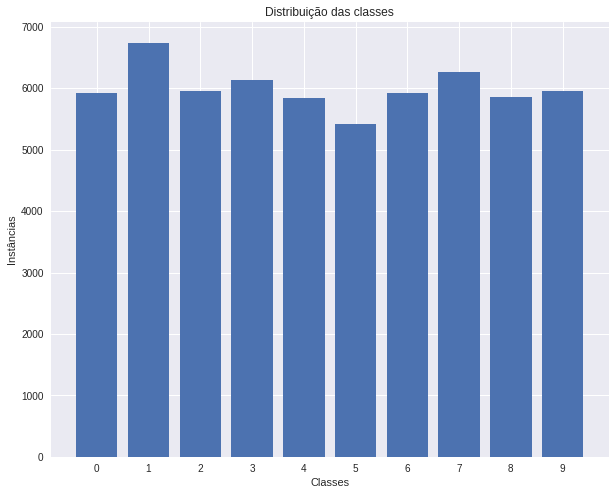

In [3]:
unique, count = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10,8))
plt.title("Distribuição das classes")
plt.bar(unique, count)
plt.xticks(unique)
plt.xlabel("Classes")
plt.ylabel("Instâncias")
plt.show()

Agora fazemos a divisão do conjunto de treino em conjunto de treino e conjundo de validação que servirá para avaliar o desempenho da nossa rede enquanto a mesma é treinada. Logo depois foi plotado alguns exemplos do nosso dataset.

In [0]:
y_train, y_test = to_categorical(y_train), to_categorical(y_test)
random_seed = 2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=random_seed)

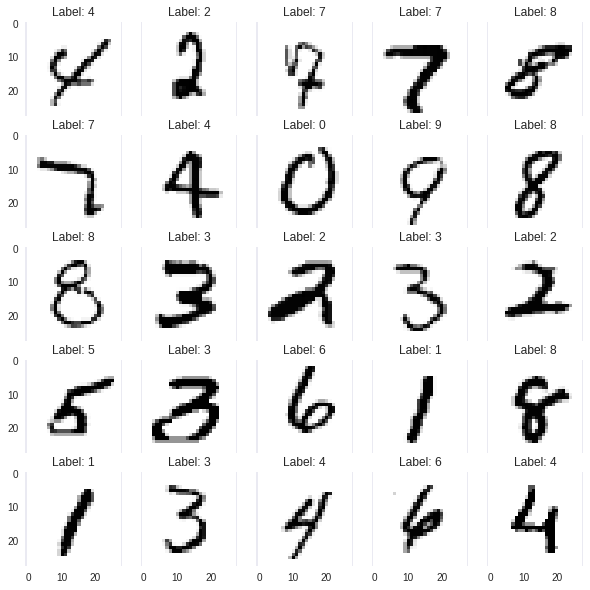

In [65]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(10,10))
index = 0
for row in range(5):
    for col in range(5):
        ax[row, col].imshow(x_train[index].reshape(28,28))
        ax[row, col].set_title("Label: {}".format(y_train[index].argmax()))
        ax[row, col].grid(False)
        index += 1

Abaixo segue a implementação do nosso modelo de CNN e logo após um sumário mostra a estrutura da rede com o número de parâmetros em cada camada assim como o número total de parâmetros treináveis. Duas camadas de Dropout foram utilizadas para que uma certa proporção de "nós" da nossa rede seja aleatoriamente ignorada, isso força que a rede extraia as features de maneira distribuída ajudando também a reduzir o overfitting.

In [0]:
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding="same",
                 activation="relu",
                 input_shape=(28,28,1)))
model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding="same",
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 padding="same",
                 activation="relu"))
model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 padding="same",
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [0]:
def check_tpu():
    try:
        tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
        print ('TPU address is', tpu_address)

        with tf.Session(tpu_address) as session:
          devices = session.list_devices()
    
        return True, tpu_address
    except Exception:
        return False, ""

In [9]:
has_tpu, tpu_address = check_tpu()
if has_tpu:
    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu_address)
        )
    )

TPU address is grpc://10.79.236.226:8470
INFO:tensorflow:Querying Tensorflow master (b'grpc://10.79.236.226:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10286764627793717633)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15454925982782434438)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 3839510994108593343)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4868800248739648966)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 13090091739542284063)
IN

Como função otimizadora nós utilizamos o RMSprop, pois ele efetua os ajustes de forma bem simples na tentativa de reduzir a agressividade e diminuindo o learning rate monotonicamente. Poderíamos ter utilizado o Stochastic Gradient Descent (SGD), mas optamos pelo RMSprop por ele apresentar um desempenho melhor.

In [0]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
if has_tpu:
    tpu_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
else:
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
epochs = 30
batch_size = 1000

In [0]:
def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, x_train.shape[0] - batch_size)
    yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]

Abaixo segue o histórico de treino para cada uma das 30 épocas que nossa rede foi submetida durante o treino.

In [14]:
if has_tpu:
    history = tpu_model.fit_generator(train_gen(batch_size),
                                      epochs=epochs,
                                      validation_data=(x_val, y_val),
                                      steps_per_epoch=x_train.shape[0]//batch_size,
                                      callbacks=[learning_rate_reduction])    
else:
    history = model.fit_generator(train_gen(batch_size),
                                      epochs=epochs,
                                      validation_data=(x_val, y_val),
                                      steps_per_epoch=x_train.shape[0]//batch_size,
                                      callbacks=[learning_rate_reduction])

Epoch 1/30
INFO:tensorflow:New input shapes; (re-)compiling: mode=train, [TensorSpec(shape=(125, 28, 28, 1), dtype=tf.float32, name='conv2d_input0'), TensorSpec(shape=(125, 10), dtype=tf.float32, name='dense_1_target0')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:Cloning RMSprop {'lr': 0.0010000000474974513, 'rho': 0.8999999761581421, 'decay': 0.0, 'epsilon': 1e-08}
INFO:tensorflow:Get updates: Tensor("loss/mul:0", shape=(), dtype=float32)
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 2.2659449577331543 secs
INFO:tensorflow:Setting weights on TPU model.
53/54 [============================>.] - ETA: 0s - loss: 0.6942 - acc: 0.7777INFO:tensorflow:New input shapes; (re-)compiling: mode=eval, [TensorSpec(shape=(125, 28, 28, 1), dtype=tf.float32, name='conv2d_input0'), TensorSpec(shape=(125, 10), dtype=tf.float32, name='dense_1_target0')]
INFO:tensorflow:Overriding default place

In [70]:
if has_tpu:
    loss, acc = tpu_model.evaluate(x_test, y_test)
    cpu_model = tpu_model.sync_to_cpu()
    predictions = cpu_model.predict(x_test)
else:
    loss, acc = model.evaluate(x_test, y_test)
    predictions = model.predict(x_test)
    
pred_labels = np.argmax(predictions, axis=1)

10000/10000 [==============================] - 2s 217us/step
INFO:tensorflow:Copying TPU weights to the CPU
Acurácia conjunto de teste: 99.6%


Como podemos ver nos gráficos plotados abaixo, a nossa rede obteve um excelente resultado com uma acurácia alta e com uma taxa de erro bastante baixa. Podemos observar também que na maioria das épocas a acurácia do conjunto de validação é maior que a acurácia do conjunto de treino, isso é bastante importante pois indica que não está acontecendo um overfit sobre o conjunto de treino.

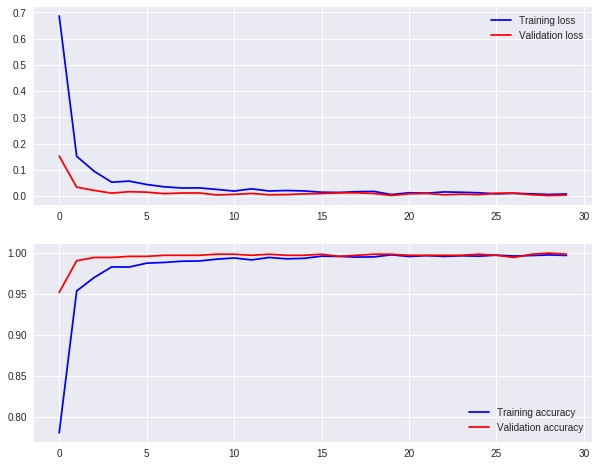

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
def plot_confusion_matrix(cm, classes):
    cmap = plt.get_cmap('Reds')
    tick_marks = classes

#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j]),
                     horizontalalignment='center',
                     color='white' if cm[i , j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

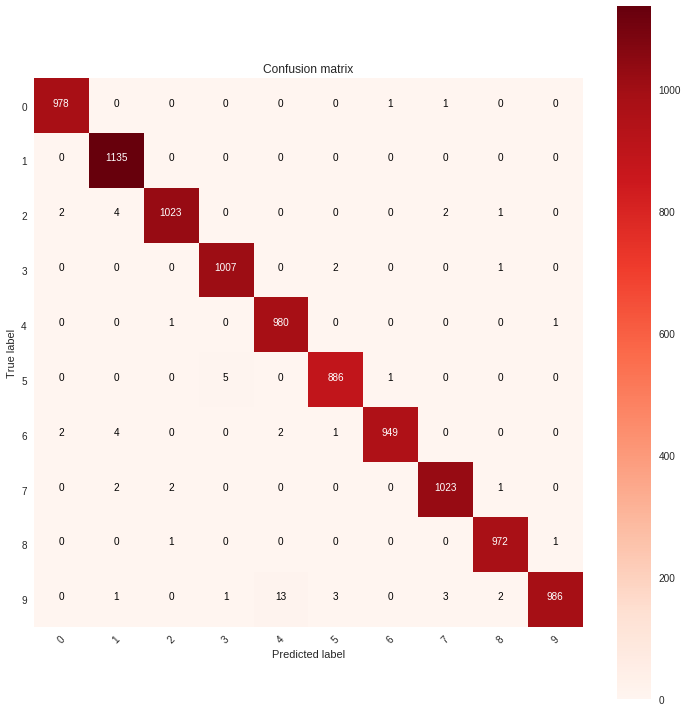

In [46]:
cm = confusion_matrix(y_test.argmax(axis=1), pred_labels)
classes = np.arange(predictions.shape[1])
plot_confusion_matrix(cm, classes)

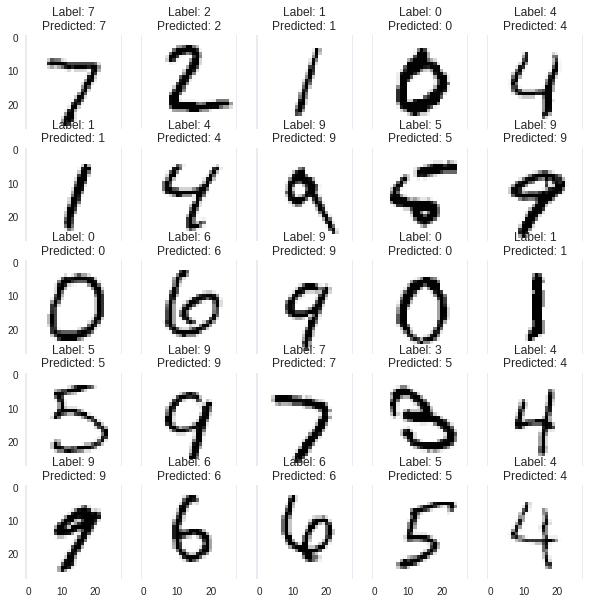

In [67]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(10,10))
index = 0
for row in range(5):
    for col in range(5):
        ax[row, col].imshow(x_test[index].reshape(28,28))
        ax[row, col].set_title("Label: {}\nPredicted: {}".format(y_test[index].argmax(),
                                                                 pred_labels[index]))
        ax[row, col].grid(False)
        index += 1